# Aula 3 - Busca local e algoritmos genéticos

## Parte 1 - busca local

Abaixo, temos a implementação do algoritmo Hill Climbing. O algoritmo recebe um estado inicial (`init_state`), uma função geradora de vizinhança (`fn_neighbours`), uma função de avaliação de soluções (`fn_evaluate`), um conjunto de valores possíveis para cada posição da solução (`possible_values`) e um número máximo de iterações (`iterations`). Ao final, o algoritmo retorna o ótimo local encontrado a partir da solução inicial.

In [ ]:
import random

def hill_climbing(init_state, fn_neighbours, fn_evaluate, possible_values, iterations=10000):
    
    current = init_state

    while iterations:

        # explore the neighbourhood
        neighbors = fn_neighbours(current, possible_values)
        if not neighbors:
            break
        
        # select the best neighbour
        neighbor = argmax_random_tie(neighbors, key=lambda node: fn_evaluate(node))

        # store the neighbour only if it is better than the current solution
        if fn_evaluate(neighbor) > fn_evaluate(current):
           current = neighbor
        iterations -= 1
        
    return current

# return the best element from the received list; ties are break uniformly at random
def argmax_random_tie(seq, key=lambda x: x):
    items = list(seq)
    random.shuffle(items)
    return max(items, key=key)

Para o algoritmo acima funcionar, precisamos de duas funções de apoio: `fn_neighbours` e `fn_evaluate`. Esta funções devem ser definidas com base na definição do problema que queremos resolver. Por exemplo, vamos considerar o problema de coloração de grafos. Em particular, vamos considerar a instância Australia deste problema, conforme a figura abaixo.

![alt text](https://www.researchgate.net/profile/Abderrazak_Daoudi/publication/325808704/figure/fig2/AS:638325140512769@1529199981896/An-example-of-graph-coloring-problem.png)

Neste problema, o objetivo é colorir os territórios do mapa de tal forma que territórios vizinhos nunca tenham a mesma cor. No exemplo acima, é fácil ver que precisamos de pelo menos três cores para resolver o problema.

Para que o computador consiga resolver este problema, naturalmente precisamos representá-lo de uma forma mais eficiente do que uma imagem. Desta forma, podemos representar o problema como um grafo, onde os nós representam territórios e as arestas denotam territórios vizinhos. 

De uma forma simples, o grafo acima pode ser representado através do dicionário a seguir, onde as chaves denotam o nome das arestas e os valores correspondentes denotam os nós conectados pela aresta. No caso abaixo, nós são representados por números, onde WA=0, NT=1, SA=2, Q=3, NSW=4, V=5 e T=6. Nota: nosso algoritmo assume que o grafo é completo, desta forma criamos uma aresta entre os nós V e T para o algoritmo funcionar.

In [ ]:
# Australia instance of the graph coloring problem; each entry represents an edge
australia = {
    'WA-NT': [0, 1],
    'WA-SA': [0, 2],
    'NT-SA': [1, 2],
    'NT-Q': [1, 3],
    'SA-Q': [2, 3],
    'SA-NSW': [2, 4],
    'SA-V': [2, 5],
    'Q-NSW': [3, 4],
    'NSW-V': [4, 5],
    'V-T': [5, 6] 
}

De modo a resolver o problema de coloração de grafos utilizando o algoritmo Hill Climbing, vamos definir uma função de vizinhança (`fn_neighbours_GC`) e uma classe de avaliação (`EvaluateGC`).

A função `fn_neighbours_GC` recebe dois argumentos. O primeiro é uma solução (`state`), que denota uma alocação qualquer de cores, sendo uma para cada estado. O segundo argumento (`possible_values`) denota o conjunto de valores possíveis para cada posição da solução. No nosso caso, esses valores denotam as cores que queremos utilizar para colorir o grafo. Para gerar a vizinhança, a função altera cada valor da solução (`state`) recebida pelos valores possíveis (`possible_values`); cada alteração individual representa um indivíduo; o conjunto destes vizinhos denota a vizinhança de `state`.

In [ ]:
def find_neighbours_GC(state, possible_values):
    
    # list of neighbours
    neighbours = []

    # for each position (i.e., territory)
    for i in range(len(state)):
        # for each possible value (i.e., colour)
        for v in possible_values:
            # if the change generates a new neighbour, create it and add to the neighbourhood list
            if state[i] != v:
              neighbour = state[:]
              neighbour[i] = v
              neighbours.append(neighbour)
    
    return neighbours

A classe `EvaluateGC` é responsável por avaliar soluções. Primeiramente, ela deve ser inicializada com a instância do problema, gerando assim um objeto. Posteriormente, para avaliar uma solução, basta chamar diretamente o objeto, passando a solução em questão como argumento. Isto faz com que o método `__call__` seja chamado, o qual recebe uma solução (`solution`) e a avalia seu valor no contexto da instância do problema considerado (`problem_instance`). No caso da coloração de grafos, este valor representa o número de pares de territórios vizinhos que possuem cores diferentes. 

Optamos por criar uma classe ao invés de uma simples função para permitir que a instância do problema seja registrada internamente na classe, permitindo assim que soluções sejam avaliadas posteriormente sem precisarmos nos preocupar em guardar a variável correspondente à instância do problema.

In [ ]:
# evaluation class; 
# since that a solution needs to be evaluated with respect to the problem instance 
# in consideration, we created this class to store the problem instance and to 
# allow the evaluation to be performed without having the problem instance at hand
class EvaluateGC:
    # during initialization, store the problem instance
    def __init__(self, problem_instance):
        self.problem_instance = problem_instance
    
    # compute the value of the received solution
    def __call__(self, solution):
        return sum(solution[n1] != solution[n2] for (n1, n2) in self.problem_instance.values())

# create an instance of the evaluation class for the considered problem instance
fn_evaluate = EvaluateGC(australia)
# now, a solution X can be evaluated by simply calling fn_evaluate(X)

Finalmente, podemos testar nosso algoritmo.

In [ ]:
# set of possible colours (red, green, blue)
possible_values = ['R', 'G', 'B'] 

# initial state; this state could be generated at random; 
# to keep it simple, here we assume that all territories have the same colour
init_state = ['R', 'R', 'R', 'R', 'R', 'R', 'R'] 

# execute the algoritm
best = hill_climbing(init_state, find_neighbours_GC, fn_evaluate, possible_values)

# print the results
print('Resulting solution: %s' % best)
print('Value of resulting solution: %d' % fn_evaluate(best))

Resulting solution: ['R', 'B', 'G', 'R', 'B', 'R', 'B']
Value of resulting solution: 10


Se você testar o código acima, verá que o algoritmo Hill Climbing encontra resultados razoavelmente bons. De fato, nesta instância do problema ele frequentemente alcança a solução ótima, cujo valor é 10. 

Abaixo, apresentamos um problema menor, onde existem apenas quatro nós e a solução ótima possui valor 4.

In [ ]:
# another instance of the graph coloring problem
another_instance = {
    'A': [0, 1],
    'B': [0, 3],
    'C': [1, 2],
    'D': [2, 3]
}

# create an instance of the evaluation class for the considered problem instance
fn_evaluate = EvaluateGC(another_instance)

# set of possible colours (red, green)
possible_values = ['R', 'G']

# initial state; this state could be generated at random; 
# to keep it simple, here we assume that all nodes have the same colour
init_state = ['R', 'R', 'R', 'R']

# run the algoritm
best = hill_climbing(init_state, find_neighbours_GC, fn_evaluate, possible_values)

# print the results
print('Resulting solution: %s' % best)
print('Value of resulting solution: %d' % fn_evaluate(best))

Resulting solution: ['G', 'R', 'G', 'R']
Value of resulting solution: 4


Note que, em ambos os exemplos acima, o problema que estamos resolvendo é o mesmo (coloração de grafos), o que muda é apenas a instância (`australia` e `another_instance`). Desta forma, em ambos os casos o algoritmo Hill Climbing utilizou as mesmas funções de vizinhança (`find_neighbours_GC`) e de avaliação (`evaluate_GC`). Para resolver outros problemas (e.g., caixeiro viajante, roteamento de veículos, etc), basta formular as instâncias dos novos problemas e as variações correspondentes das funções `find_neighbours` e `evaluate`. Feito isso, o mesmo algoritmo Hill Climbing deve funcionar sem problemas.

### Exercício 1

Codifique a instância do problema de coloração de grafos abaixo. Trata-se do [grafo de Petersen](https://pt.wikipedia.org/wiki/Grafo_de_Petersen). O número de cores possíveis aqui continua sendo 3. Em seguida, rode o algoritmo Hill Climbing. O valor ótimo aqui é 15.

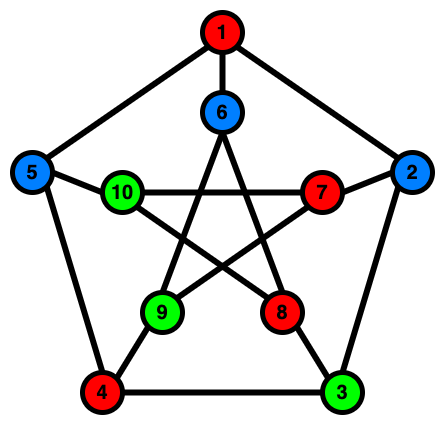

In [ ]:
# Petersen graph
petersen = {
    '1-2': [0, 1],
    '2-3': [1, 2],
    '3-4': [2, 3],
    '4-5': [3, 4],
    '5-1': [4, 0],
    '1-6': [0, 5],
    '2-7': [1, 6],
    '3-8': [2, 7],
    '4-9': [3, 8],
    '5-10': [4, 9],
    '6-8': [5, 7],
    '6-9': [5, 8],
    '7-9': [6, 8],
    '7-10': [6, 9],
    '8-10': [7, 9]
}

# create an instance of the evaluation class for the considered problem instance
fn_evaluate = EvaluateGC(petersen)

# set of possible colours (red, green, blue)
possible_values = ['R', 'G', 'B']

# initial state; this state could be generated at random; 
# to keep it simple, here we assume that all nodes have the same colour
init_state = ['R' for _ in range(10)]

# run the algoritm
best = hill_climbing(init_state, find_neighbours_GC, fn_evaluate, possible_values)

# print the results
print('Resulting solution: %s' % best)
print('Value of resulting solution: %d' % fn_evaluate(best))

Resulting solution: ['B', 'G', 'R', 'B', 'R', 'G', 'B', 'B', 'R', 'G']
Value of resulting solution: 15


### Exercício 2

Codifique o problema das n-rainhas. Considere a instância de tamanho 8 (i.e., 8-rainhas), conforme imagem abaixo. Em seguida, rode o algoritmo Hill Climbing. Na solução ótima, nenhuma rainha consegue atacar as demais.

![alt text](https://www.researchgate.net/publication/333815714/figure/fig1/AS:770619155156992@1560741332335/A-visual-representation-of-a-solution-for-the-8-queens-problem-left-and-the-variables.png)

Primeiramente, implemente a classe `EvaluateNQueens`. Considerando que nossa implementação do Hill Climbing maximiza o valor das soluções, devemos implementar o método `__call__` de modo a retornar o número negativo de conflitos. Exemplo: ao receber uma solução com 2 conflitos, a função deve retornar -2.

In [ ]:
# evaluation class for the n-Queens problem
class EvaluateNQueens:
    # during initialization, store the problem instance
    def __init__(self, n):
        self.n = n
    
    # compute the value of the received solution
    def __call__(self, solution):
        conflicts = 0

        for (c1, r1) in enumerate(solution):
          for (c2, r2) in enumerate(solution):
            if c2 <= c1:
              continue
            if (r1, c1) != (r2, c2):
              if (r1 == r2) or (c1 == c2) or (r1 - c1 == r2 - c2) or (r1 + c1 == r2 + c2):
                conflicts+=1

        # our hill climbing implementation maximises the value; 
        # thus, instead of returning only the number of conflicts (which we  
        # would want to minimise instead of maximise), we return its negative
        return -conflicts 

Em seguida, implemente a função `find_neighbours_NQueens` para encontrar os vizinhos de uma dada solução. Para isto, enumere as possíveis modificações de cada posição da solução e armazene cada vizinho encontrado.

In [ ]:
def find_neighbours_NQueens(state, possible_values): #same as in graph coloring
    
    # list of neighbours
    neighbours = []

    # for each position
    for i in range(len(state)):
        # for each possible value
        for v in possible_values:
            # if the change generates a new neighbour, create it and add to the neighbourhood list
            if state[i] != v:
              neighbour = state[:]
              neighbour[i] = v
              neighbours.append(neighbour)
    
    return neighbours

Finalmente, o algoritmo pode ser executado como segue.

In [ ]:
# instance of the N-Queens problem
n = 8

# create an instance of the evaluation class for the considered problem instance
fn_evaluate = EvaluateNQueens(n)

# set of possible values 
possible_values = [x for x in range(n)]

# initial state (we begin with a solution where all queens are on the same row)
init_state = [0 for _ in range(n)]

# run the algoritm
best = hill_climbing(init_state, find_neighbours_NQueens, fn_evaluate, possible_values)

# print the results
print('Resulting solution: %s' % best)
print('Value of resulting solution (the closer to zero the best): %d' % fn_evaluate(best))

Resulting solution: [6, 0, 2, 0, 5, 7, 4, 1]
Value of resulting solution (the closer to zero the best): -1


## Parte 2 - algoritmos genéticos

Abaixo, temos a implementação de um algoritmo genético. O algoritmo recebe uma população inicial (`population`), uma função de avaliação de soluções (`fn_fitness`), um conjunto de valores possíveis para cada posição da solução (`gene_pool`), uma função de critério de parada por qualidade da solução (`fn_thres`), um número máximo de gerações (`ngen`) e uma probabilidade de mutação (`pmut`). Ao final, o algoritmo retorna o melhor indivíduo (solução) da última geração de indivíduos.

In [ ]:
import random as random
import bisect

def genetic_algorithm(population, fn_fitness, gene_pool, fn_thres=None, ngen=1000, pmut=0.1):
    
    # for each generation
    for i in range(ngen):

        # create a new population
        new_population = []

        # repeat to create len(population) individuals
        for i in range(len(population)):
          
          # select the parents
          p1, p2 = select(2, population, fn_fitness)

          # recombine the parents, thus producing the child
          child = recombine(p1, p2)

          # mutate the child
          child = mutate(child, gene_pool, pmut)

          # add the child to the new population
          new_population.append(child)

        # move to the new population
        population = new_population

        # check if one of the individuals achieved a fitness of fn_thres; if so, return it
        fittest_individual = fitness_threshold(fn_fitness, fn_thres, population)
        if fittest_individual:
            return fittest_individual

    # return the individual with highest fitness
    return max(population, key=fn_fitness)
  
# get the best individual of the received population and return it if its 
# fitness is higher than the specified threshold fn_thres
def fitness_threshold(fn_fitness, fn_thres, population):
    if not fn_thres:
        return None

    fittest_individual = max(population, key=fn_fitness)
    if fn_fitness(fittest_individual) >= fn_thres:
        return fittest_individual

    return None

Para o algoritmo acima funcionar, precisamos das seguintes funções de apoio: `fn_fitness`, `select`, `recombine` e `mutate`. A primeira função deve ser definida com base na definição do problema que queremos resolver (como no exemplo anterior, onde foi criada a função `fn_evaluate_GC` para o problema de coloração de grafos). As demais funções, por outro lado, tendem a ser mais genéricas, representando o que chamamos de operadores genéticos. Naturalmente, nem todos operadores genéticos funcionam bem em todos os problemas. Desta forma, devemos escolhar os operadores genéticos com base no problema em questão.

A função `select` abaixo implementa o operador genético de seleção. Em particular, é implementada a seleção da roleta (ou seleção proporcional à aptidão). Neste método, a partir da população (`population`) e função de aptidão (`fn_fitness`) recebidas, o método retorna `r` indivíduos aleatoriamente, onde a probabilidade de um dado indivíduo ser selecionado é proporcional à sua aptidão. Este tipo de seleção faz bastante sentido na prática, pois garante que indivíduos mais aptos têm chances maiores de produzir filhos.

In [ ]:
# genetic operator for selection of individuals; 
# this function implements roulette wheel selection, where individuals with 
# higher fitness are selected with higher probability
def select(r, population, fn_fitness):
    fitnesses = map(fn_fitness, population)
    sampler = weighted_sampler(population, fitnesses)
    return [sampler() for i in range(r)]

# return a single sample from seq; the probability of a sample being returned
# is proportional to its weight
def weighted_sampler(seq, weights):
    totals = []
    for w in weights:
        totals.append(w + totals[-1] if totals else w)
    return lambda: seq[bisect.bisect(totals, random.uniform(0, totals[-1]))]

A função `recombine` abaixo implementa o operador genético de recombinação (ou cruzamento). Em particular, a função implementa a recombinação de ponto único, onde um número aleatório `c` é gerado para dividir as porções iniciais (índices 0 a c) e finais (índices c a n) dos pais (`x` e `y`). O filho é então produzido a partir da porção inicial de um dos pais e a porção final do outro.

In [ ]:
# genetic operator for recombination (crossover) of individuals; 
# this function implements single-point crossover, where the resulting individual
# carries a portion [0,c] from parent x and a portion [c,n] from parent y, with 
# c selected at random
def recombine(x, y):
    n = len(x)
    c = random.randrange(0, n)
    return x[:c] + y[c:]

A função `mutate` abaixo implementa o operador genético de mutação. Em particular, a função implementa a mutação uniforme no indivíduo recebido `x`. Nesta mutação, um gene (posição) do indivíduo é selecionado de forma aleatória e seu valor é substituído por um dos valores possíveis (`gene_pool`) aleatoriamente. Vale observar que o indivíduo `x` só sofre mutação com probabilidade `pmut`. Note ainda que neste método apenas um gene sofre mutação.

In [ ]:
# genetic operator for mutation; 
# this function implements uniform mutation, where a single element of the 
# individual is selected at random and its value is changed by a randomly chosen 
# value (out of the possible values in gene_pool)
def mutate(x, gene_pool, pmut):
    
    # if random >= pmut, then no mutation is performed
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n) # gene to be mutated
    r = random.randrange(0, g) # new value of the selected gene

    new_gene = gene_pool[r]
    return x[:c] + [new_gene] + x[c+1:]

Definidos os operadores acima, agora precisamos criar um método para gerar a população inicial. Esta população deve ser gerada de forma aleatória. A função `init_population` faz exatamente isso. Para tal, ela recebe três parâmetros. O primeiro (`pop_number`) especifica o tamanho da população. O segundo (`gene_pool`) define os valores possíveis para os genes de cada indivíduo. O terceiro (`state_length`) denota o número de genes de cada indivíduo. Ao final, a função abaixo retorna uma lista com a população de indivíduos.

In [ ]:
def init_population(pop_number, gene_pool, state_length):
    g = len(gene_pool)
    population = []
    for i in range(pop_number):
        # each individual is represented as an array with size state_length, 
        # where each position contains a value from gene_pool selected at random
        new_individual = [gene_pool[random.randrange(0, g)] for j in range(state_length)]
        population.append(new_individual)

    return population

Agora podemos nos preocupar com o problema em si. Vamos considerar novamente o problema de coloração de grafos visto anteriormente.

In [ ]:
# Australia instance of the graph coloring problem; each entry represents an edge
problem_instance = {
    'WA-NT': [0, 1],
    'WA-SA': [0, 2],
    'NT-SA': [1, 2],
    'NT-Q': [1, 3],
    'SA-Q': [2, 3],
    'SA-NSW': [2, 4],
    'SA-V': [2, 5],
    'Q-NSW': [3, 4],
    'NSW-V': [4, 5],
    'V-T': [5, 6] 
}

# set of possible colours (red, green, blue)
possible_values = ['R', 'G', 'B'] 

# length of an individual (one position per territory)
individual_length = 7

Para avaliar a aptidão dos indivíduos no problema de coloração de grafos, podemos utilizar a mesma classe que vimos anteriomente. Esta classe calcula a aptdidão de um indivíduo como o número de pares de territórios vizinhos que possuem cores diferentes. Lembrando que quanto maior este número, melhor. 

In [ ]:
# evaluation class; 
# since that a solution needs to be evaluated with respect to the problem instance 
# in consideration, we created this class to store the problem instance and to 
# allow the evaluation to be performed without having the problem instance at hand
class EvaluateGC:
    # during initialization, store the problem instance
    def __init__(self, problem_instance):
        self.problem_instance = problem_instance
    
    # compute the value of the received solution
    def __call__(self, solution):
        return sum(solution[n1] != solution[n2] for (n1, n2) in self.problem_instance.values())

# create an instance of the evaluation class for the considered problem instance
fn_fitness = EvaluateGC(australia)
# now, a solution X can be evaluated by simply calling fn_fitness(X)

Agora, finalmente, podemos testar nosso algoritmo.

In [ ]:
# population size
population_size = 8

# initial population
population = init_population(population_size, possible_values, individual_length)

# run the algoritm
solution = genetic_algorithm(population, fn_fitness, gene_pool=possible_values, fn_thres=10)

# print the results
print('Resulting solution: %s' % solution)
print('Value of resulting solution: %d' % fn_fitness(solution))

Resulting solution: ['G', 'B', 'R', 'G', 'B', 'G', 'R']
Value of resulting solution: 10


Se você testar o código acima, verá que o algoritmo genético consegue encontrar o resultado ótimo com uma certa facilidade nesta instância do problema de coloração de grafos. Lembrando que, nesta instância, a solução ótima possui um valor de 10.

Novamente, lembre que o problema que estamos resolvendo aqui é o de coloração de grafos. Da mesma forma que vimos anteriormente, podemos utilizar este algoritmo para resolver outras instâncias do mesmo problema, bastando especificar as variáveis `problem_instance`, `possible_values`, `individual_length` e `fn_fitness` correspondentes.

Naturalmente, dependendo do problema a ser considerado, pode ser necessário ainda ajustar também alguns elementos do algoritmo, como os operadores genéticos. Os operadores genéticos sempre devem ser escolhidos com base na estrutura do problema.

### Exercício 3

Utilize o algoritmo genético para resolver a instância "grafo de Petersen" do problema de coloração de grafos. O número de cores possíveis aqui continua sendo 3 e o valor ótimo permanece sendo 15.

In [ ]:
# Petersen graph
petersen = {
    '1-2': [0, 1],
    '2-3': [1, 2],
    '3-4': [2, 3],
    '4-5': [3, 4],
    '5-1': [4, 0],
    '1-6': [0, 5],
    '2-7': [1, 6],
    '3-8': [2, 7],
    '4-9': [3, 8],
    '5-10': [4, 9],
    '6-8': [5, 7],
    '6-9': [5, 8],
    '7-9': [6, 8],
    '7-10': [6, 9],
    '8-10': [7, 9]
}

# set of possible colours
possible_values = ['R', 'G', 'B']

# length of an individual (one position per territory)
individual_length = 10

# create an instance of the evaluation class for the considered problem instance
fn_evaluate = EvaluateGC(petersen)

# population size
population_size = 8

# initial population
population = init_population(population_size, possible_values, individual_length)

# run the algoritm
solution = genetic_algorithm(population, fn_evaluate, gene_pool=possible_values, fn_thres=15)

# print the results
print('Resulting solution: %s' % solution)
print('Value of resulting solution: %d' % fn_evaluate(solution))

Resulting solution: ['B', 'G', 'R', 'B', 'G', 'G', 'B', 'B', 'R', 'R']
Value of resulting solution: 15


### Exercício 4

Utilize o algoritmo genético para resolver a instância 8-rainhas do problema n-rainhas. Lembrando que na solução ótima nenhuma rainha consegue atacar as demais.

Primeiramente, implemente a classe `EvaluateNQueens`. Note que nossa implementação do operador de seleção não lida bem com valores negativos. Desta forma, devemos implementar o método `__call__` de modo a retornar um valor no intervalo $[0,max\_conflicts]$. O número máximo de conflitos no n-Queens é $\frac{n(n-1)}{2}$. Exemplo: para $n=8$, temos no máximo 28 conflitos; logo, ao receber uma solução com 7 conflitos, a função deve retornar 21.

In [ ]:
# evaluation class for the n-Queens problem
class EvaluateNQueens:
    # during initialization, store the problem instance
    def __init__(self, n):
        self.n = n
    
    # compute the value of the received solution
    def __call__(self, solution):
        conflicts = 0

        for (c1, r1) in enumerate(solution):
          for (c2, r2) in enumerate(solution):
            if c2 <= c1:
              continue
            if (r1, c1) != (r2, c2):
              if (r1 == r2) or (c1 == c2) or (r1 - c1 == r2 - c2) or (r1 + c1 == r2 + c2):
                conflicts+=1

        # our genetic algorithm implementation maximises the value; 
        # moreover, its selection operator does not handle negative values properly; 
        # thus, we estimate the maximum possible number of conflicts (which is 
        # given by n(n-1)/2) and subtract from it the number of conflicts of the
        # received solution; this allows our algorithm to maximize the fitness;
        # hence, our objective here is to get as close to n(n-1)/2 as possible
        return ((self.n * (self.n - 1)))/2 - conflicts 

Agora, implemente a instanciação do problema, configure o algoritmo genético e execute o mesmo.

In [ ]:
# instance of the N-Queens problem
n = 8

# create an instance of the evaluation class for the considered problem instance
fn_evaluate = EvaluateNQueens(n)

# set of possible values 
possible_values = [x for x in range(n)]

# initial state (we begin with a solution where all queens are on the same row)
init_state = [0 for _ in range(n)]

# population size
population_size = 8

# initial population
population = init_population(population_size, possible_values, n)

# run the algoritm
solution = genetic_algorithm(population, fn_evaluate, gene_pool=possible_values, fn_thres=28, ngen=1000)

# print the results
print('Resulting solution: %s' % solution)
print('Value of resulting solution (the higher the better): %d' % fn_evaluate(solution))

Resulting solution: [7, 1, 4, 6, 6, 5, 0, 5]
Value of resulting solution (the higher the better): 22


Observe que mesmo aumentando o número de gerações para 10000, nossa implementação do algoritmo genético não conseguiu encontrar o resultado ótimo, que no problema 8-rainhas corresponde a 28.

### Exercício 5

Implemente o operador de mutação do algoritmo genético. Existem diversas possibilidades aqui. Uma sugestão é a mutação baseada em troca de posições (swap), onde duas posições são selecionadas aleatoriamente e seus valores são trocados. Mais detalhes (e outras opções) em: [link 1](https://link.springer.com/chapter/10.1007/978-1-4614-6940-7_4), [link 2](https://www.inf.ufsc.br/~alexandre.goncalves.silva/courses/14s2/ine5633/slides/aulaAG.pdf), [link 3](https://sites.icmc.usp.br/andre/research/genetic/) e [link 4](http://www2.peq.coppe.ufrj.br/Pessoal/Professores/Arge/COQ897/Naturais/aulas_piloto/aula4.pdf). Em seguida, rode o algoritmo nos problemas dos dois exercícios anteriores e compare o resultado das execuções do algoritmo genético com a mutação original e a criada aqui.

In [ ]:
def mutate(x, gene_pool, pmut):
    
    # if random >= pmut, then no mutation is performed
    if random.uniform(0, 1) >= pmut:
        return x
    
    n = len(x)

    # select two different positions at random
    p1 = random.randrange(0, n)
    p2 = p1
    while p1 == p2:
      p2 = random.randrange(0, n)
    
    # exchange their values
    aux = x[p1]
    x[p1] = x[p2]
    x[p2] = aux

    # return the mutated individual
    return x[:]

Agora, execute o algoritmo genético anterior com o novo operador de mutação.

In [ ]:
# run the algoritm
solution = genetic_algorithm(population, fn_evaluate, gene_pool=possible_values, fn_thres=28, ngen=1000)

# print the results
print('Resulting solution: %s' % solution)
print('Value of resulting solution (the higher the better): %d' % fn_evaluate(solution))

Resulting solution: [4, 4, 3, 4, 4, 3, 3, 3]
Value of resulting solution (the higher the better): 13


No código acima, criamos um operador de mutação baseado em swap. Note que o resultado do algoritmo piora significativamente. O problema aqui não é a mutação em si, mas o cruzamento, que acaba inserindo muitos elementos repetidos.

Para lidar com este problema, vamos implentar um operador de cruzamento que evita a inserção de elementos repetidos. O nome deste operador é "Order 1 Crossover". Basicamente, este operador seleciona um trecho do pai X e passa para o indivíduo filho. Em seguida, os elementos faltantes são pegos da mãe em ordem, mas ignorando os elementos já copiados do pai. Mais detalhes [aqui](https://arxiv.org/pdf/1802.02006.pdf).

In [ ]:
def recombine(x,y):
  
  n = len(x)

  # select two different positions at random
  p1 = random.randrange(0, n)
  p2 = p1
  while p1 == p2:
    p2 = random.randrange(0, n)
  
  # ensure that p1 < p2
  aux = max(p1,p2)
  p1 = min(p1,p2)
  p2 = aux

  # select the elements in y that are not in x[p1:p2+1]
  remaining = [i for i in y if i not in x[p1:p2+1]]

  # create the final individual
  return remaining[:p1] + x[p1:p2+1] + remaining[p1:]

Finalmente, podemos testar o algoritmo com o novo operador de cruzamento.

In [ ]:
# run the algoritm
solution = genetic_algorithm(population, fn_evaluate, gene_pool=possible_values, fn_thres=28, ngen=1000)

# print the results
print('Resulting solution: %s' % solution)
print('Value of resulting solution (the higher the better): %d' % fn_evaluate(solution))

Resulting solution: [4, 1, 3, 5, 7, 2, 0, 6]
Value of resulting solution (the higher the better): 28


Como pode ser observado, o resultado ficou consideravelmente melhor.